<a href="https://colab.research.google.com/github/UttaraKet1607/Malarial-Cell-Image-Segmentation/blob/main/Autoencoder_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image classification using reconstructed output of autoencoder for malaria cell images

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download iarunava/cell-images-for-detecting-malaria
! unzip cell-images-for-detecting-malaria.zip

## Imports

In [6]:
import os
import json
import glob
import datetime
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import subtract, Activation, Conv2D, DepthwiseConv2D, MaxPooling2D, Dropout, LeakyReLU

In [7]:
tf.__version__

'2.8.0'

### Set logging to Error only

In [8]:
tf.get_logger().setLevel('ERROR')

### Check for GPU

In [9]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')

if len(physical_devices) > 0:
   tf.config.experimental.set_memory_growth(physical_devices[0], True)

physical_devices

[]

## Constants

### Loading config file

In [11]:
with open("configs.json", "r") as f:
    configs = json.load(f)

cfg_common = configs["COMMON"]
cfg_reconstruction = configs["RECONSTRUCTION"]
cfg_classification = configs["CLASSIFICATION"]

### Data Preparation

In [12]:
RANDOM_STATE = cfg_common["RANDOM_STATE"]
UNIFECTED_BASE_PATH = cfg_common["BASE_PATH"]["UNINFECTED"]
PARASITIZED_BASE_PATH = cfg_common["BASE_PATH"]["PARASITIZED"]
IMAGE_SIZE = cfg_common["IMAGE_SIZE"]
VAL_SIZE = cfg_classification["DATA"]["VAL_SIZE"]
BATCH_SIZE = cfg_classification["DATA"]["BATCH_SIZE"]

### Training

In [13]:
EPOCHS = cfg_classification["TRAINING"]["EPOCHS"]
LEARNING_RATE = cfg_classification["TRAINING"]["LEARNING_RATE"]

Callbacks

In [14]:
TB_LOGS = cfg_classification["TRAINING"]["TENSORBOARD_LOG_BASE_DIR"] + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

### Saving

In [15]:
MODEL_NAME = cfg_classification["MODEL_NAME"]
PLOTS_DPI = cfg_common["PLOTS_DPI"]
PLOTS_DIR = cfg_classification["PLOTS_DIR"]

## Data Loading

### Label Encoding and Decoding

In [16]:
labelEncoding = {
    'Uninfected' : 0,
    'Parasitized' : 1
}

labelEncoding

{'Parasitized': 1, 'Uninfected': 0}

In [17]:
labelDecoding = {v: k for k, v in labelEncoding.items()}
labelDecoding

{0: 'Uninfected', 1: 'Parasitized'}

### Loading image filenames

In [18]:
uninfectedImageNames = [os.path.basename(file) for file in glob.glob(os.path.join(UNIFECTED_BASE_PATH, '*.png'))]

print(f"\nTotal number of uninfected cell image files: {len(uninfectedImageNames)}")


Total number of uninfected cell image files: 13779


In [19]:
parasitizedImageNames = [os.path.basename(file) for file in glob.glob(os.path.join(PARASITIZED_BASE_PATH, '*.png'))]

print(f"\nTotal number of parasitized cell image files: {len(parasitizedImageNames)}")


Total number of parasitized cell image files: 13779


### Loading image data

In [22]:
import cv2
from keras.preprocessing.image import img_to_array

In [24]:
%%time

imageData = []
imageLabels = []

for img in uninfectedImageNames:
    img_read = plt.imread('/content/cell_images/Uninfected' + "/" + img)
    img_resize = cv2.resize(img_read, (50, 50))
    img_array = img_to_array(img_resize)
    imageData.append(img_array)
    imageLabels.append(labelEncoding['Uninfected'])

for img in parasitizedImageNames:
    img_read = plt.imread('/content/cell_images/Parasitized' + "/" + img)
    img_resize = cv2.resize(img_read, (50, 50))
    img_array = img_to_array(img_resize)
    imageData.append(img_array)
    imageLabels.append(labelEncoding['Parasitized'])

imageData = np.array(imageData).astype('float32')

imageLabels = np.array(imageLabels).astype('int32')


print(f'\nData type of image data: {imageData.dtype}')
print(f'\nShape of image data: {imageData.shape}')
print(f'\nData type of image labels: {imageLabels.dtype}')
print(f'\nShape of image labels: {imageLabels.shape}')


Data type of image data: float32

Shape of image data: (27558, 50, 50, 3)

Data type of image labels: int32

Shape of image labels: (27558,)
CPU times: user 43.8 s, sys: 1.17 s, total: 44.9 s
Wall time: 45.2 s


### Data splitting

In [25]:
X_train, X_val, Y_train, Y_val = train_test_split(
    imageData, 
    imageLabels,
    test_size = VAL_SIZE, 
    random_state = RANDOM_STATE,
    stratify = imageLabels
    )

print(f'Training Images: {X_train.shape}')
print(f'\nTraining Labels: {Y_train.shape}')
print(f'\nValidation Data: {X_val.shape}')
print(f'\nValidation Labels: {Y_val.shape}')

Training Images: (26180, 50, 50, 3)

Training Labels: (26180,)

Validation Data: (1378, 50, 50, 3)

Validation Labels: (1378,)


### Memory usage reduction

In [26]:
del uninfectedImageNames
del parasitizedImageNames
del imageData
del imageLabels

## Data Generators

### Training data generator

In [27]:
train_gen = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    vertical_flip = True
    )

train_data = train_gen.flow(x = X_train, y = Y_train, batch_size = BATCH_SIZE, shuffle = True)

len(train_data)

410

### Training data samples

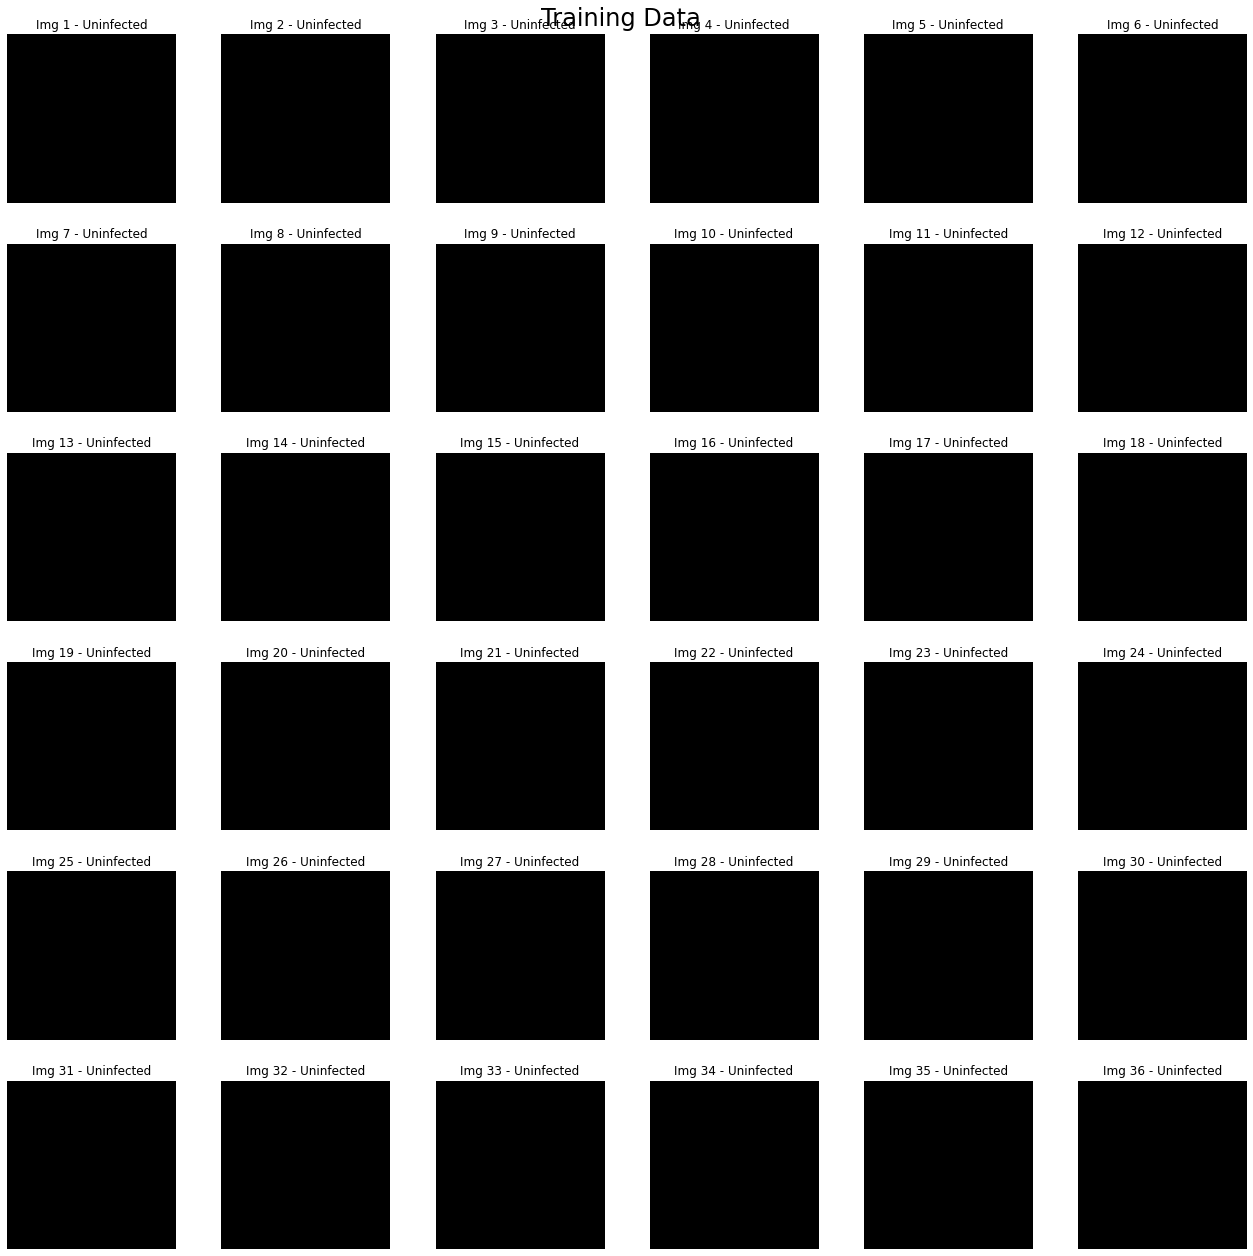

In [28]:
plt.subplots(nrows = 6, ncols = 6, figsize = (18, 18))

plt.suptitle('Training Data', fontsize = 24)
plt.tight_layout(rect = [0, 0, 1, 0.97], h_pad = 2)

gen_data = train_data.next()

for i in range(36):
    plt.subplot(6, 6, i + 1)
    plt.axis(False)
    plt.grid(False)
    plt.title(f"Img {i + 1} - {labelDecoding[gen_data[1][i]]}")
    plt.imshow(gen_data[0][i])

plt.show()

### Validation data generator

In [29]:
val_gen = ImageDataGenerator(rescale = 1./255)

val_data = val_gen.flow(x = X_val, y = Y_val, batch_size = BATCH_SIZE, shuffle = True)

len(val_data)

22

### Validation data samples

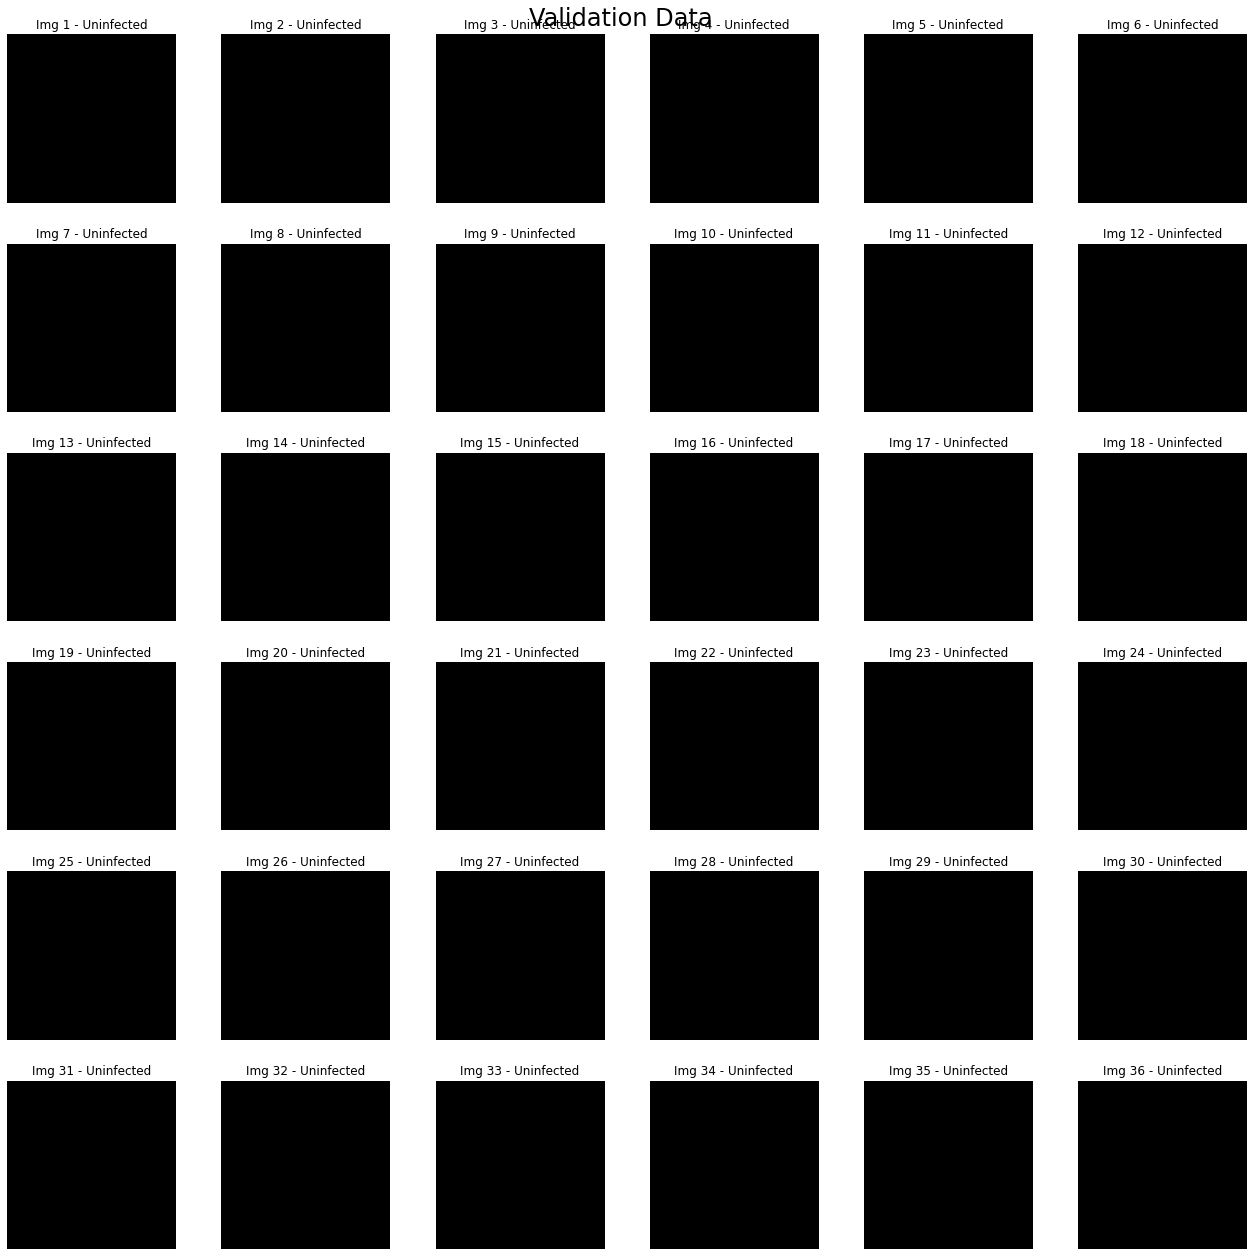

In [30]:
plt.subplots(nrows = 6, ncols = 6, figsize = (18, 18))

plt.suptitle('Validation Data', fontsize = 24)
plt.tight_layout(rect = [0, 0, 1, 0.97], h_pad = 2)

gen_data = val_data.next()

for i in range(36):
    plt.subplot(6, 6, i + 1)
    plt.axis(False)
    plt.grid(False)
    plt.title(f"Img {i + 1} - {labelDecoding[gen_data[1][i]]}")
    plt.imshow(gen_data[0][i])

plt.show()

## Model Creation

### Loading of autoencoder reconstruction model and freezing all existing layers

In [ ]:
autoencoder = tf.keras.models.load_model(cfg_reconstruction["SAVED_MODEL_DIR"])

for layer in autoencoder.layers:
    layer.trainable = False

autoencoder.summary()

Model: "Autoencoder_Reconstruction"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 128, 128, 3)]     0         
_________________________________________________________________
Depth_Conv (SeparableConv2D) (None, 128, 128, 16)      112       
_________________________________________________________________
Enc_Conv_1 (Conv2D)          (None, 128, 128, 32)      4640      
_________________________________________________________________
Enc_MaxPool_1 (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
Enc_Conv_2 (Conv2D)          (None, 32, 32, 64)        18496     
_________________________________________________________________
Enc_MaxPool_2 (MaxPooling2D) (None, 8, 8, 64)          0         
_________________________________________________________________
Enc_Conv_3 (Conv2D)          (None, 8, 8

### Autoencoder Predictions

Note how the autoencoder fails to capture the details of the spots on the parasitized images in its predictions. This is because it was trained it only the uninfected cell images. Hence the autoencoder tries to predict a reconstructed image that resembles an uninfected cell even if the input was an image of a parasitized cell. This difference in the reconstruction error would be used to classify the images using our classifier model.

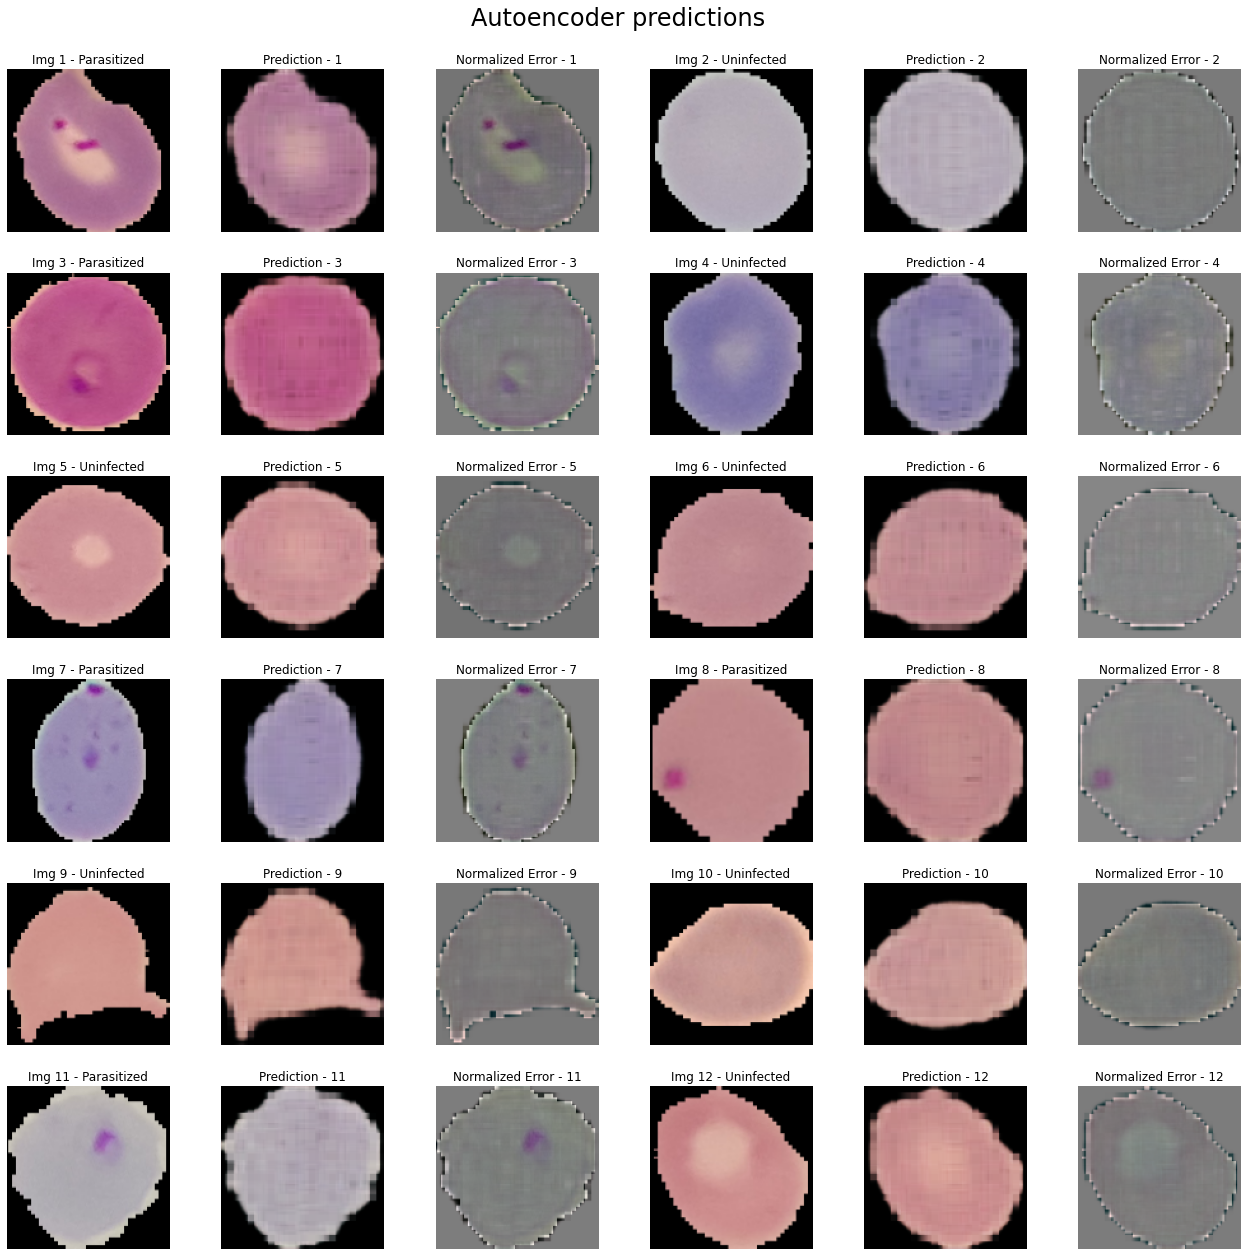

In [ ]:
plt.subplots(nrows = 6, ncols = 6, figsize = (18, 18))

plt.suptitle('Autoencoder predictions', fontsize = 24)
plt.tight_layout(rect = [0, 0, 1, 0.97], h_pad = 2)

gen_data = train_data.next()
pred = autoencoder.predict(gen_data[0][:12])
pred_error = gen_data[0][:12] - pred
pred_error_min = pred_error.min(axis = (1, 2, 3)).reshape(12, 1, 1, 1)
pred_error_max = pred_error.max(axis = (1, 2, 3)).reshape(12, 1, 1, 1)
norm_error = (pred_error - pred_error_min)/(pred_error_max - pred_error_min)

for i in range(len(pred)):
    plt.subplot(6, 6, (3 * i) + 1)
    plt.axis(False)
    plt.grid(False)
    plt.title(f"Img {i + 1} - {labelDecoding[gen_data[1][i]]}")
    plt.imshow(gen_data[0][i])

    plt.subplot(6, 6, (3 * i) + 2)
    plt.axis(False)
    plt.grid(False)
    plt.title(f"Prediction - {i + 1}")
    plt.imshow(pred[i])

    plt.subplot(6, 6, (3 * i) + 3)
    plt.axis(False)
    plt.grid(False)
    plt.title(f"Normalized Error - {i + 1}")
    plt.imshow(norm_error[i])

plt.savefig(os.path.join(PLOTS_DIR, 'autoencoder_predictions.jpg'), dpi = PLOTS_DPI, bbox_inches = 'tight')
plt.show()

### Reconstruction Error Layer

In [ ]:
reconstructionErrorLayer = subtract([autoencoder.input, autoencoder.output], name = "Reconstruction_Error")
reconstructionErrorLayer.shape

TensorShape([None, 128, 128, 3])

### Model compilation and summary

In [ ]:
classifier = Model(inputs = autoencoder.input, outputs = reconstructionErrorLayer, name = MODEL_NAME)

classifier.compile(
    optimizer = Adam(LEARNING_RATE), 
    loss = 'sparse_categorical_crossentropy', 
    metrics = ['sparse_categorical_accuracy']
    )

classifier.summary()

Model: "Autoencoder_Classification"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Depth_Conv (SeparableConv2D)    (None, 128, 128, 16) 112         Input[0][0]                      
__________________________________________________________________________________________________
Enc_Conv_1 (Conv2D)             (None, 128, 128, 32) 4640        Depth_Conv[0][0]                 
__________________________________________________________________________________________________
Enc_MaxPool_1 (MaxPooling2D)    (None, 32, 32, 32)   0           Enc_Conv_1[0][0]                 
_________________________________________________________________________

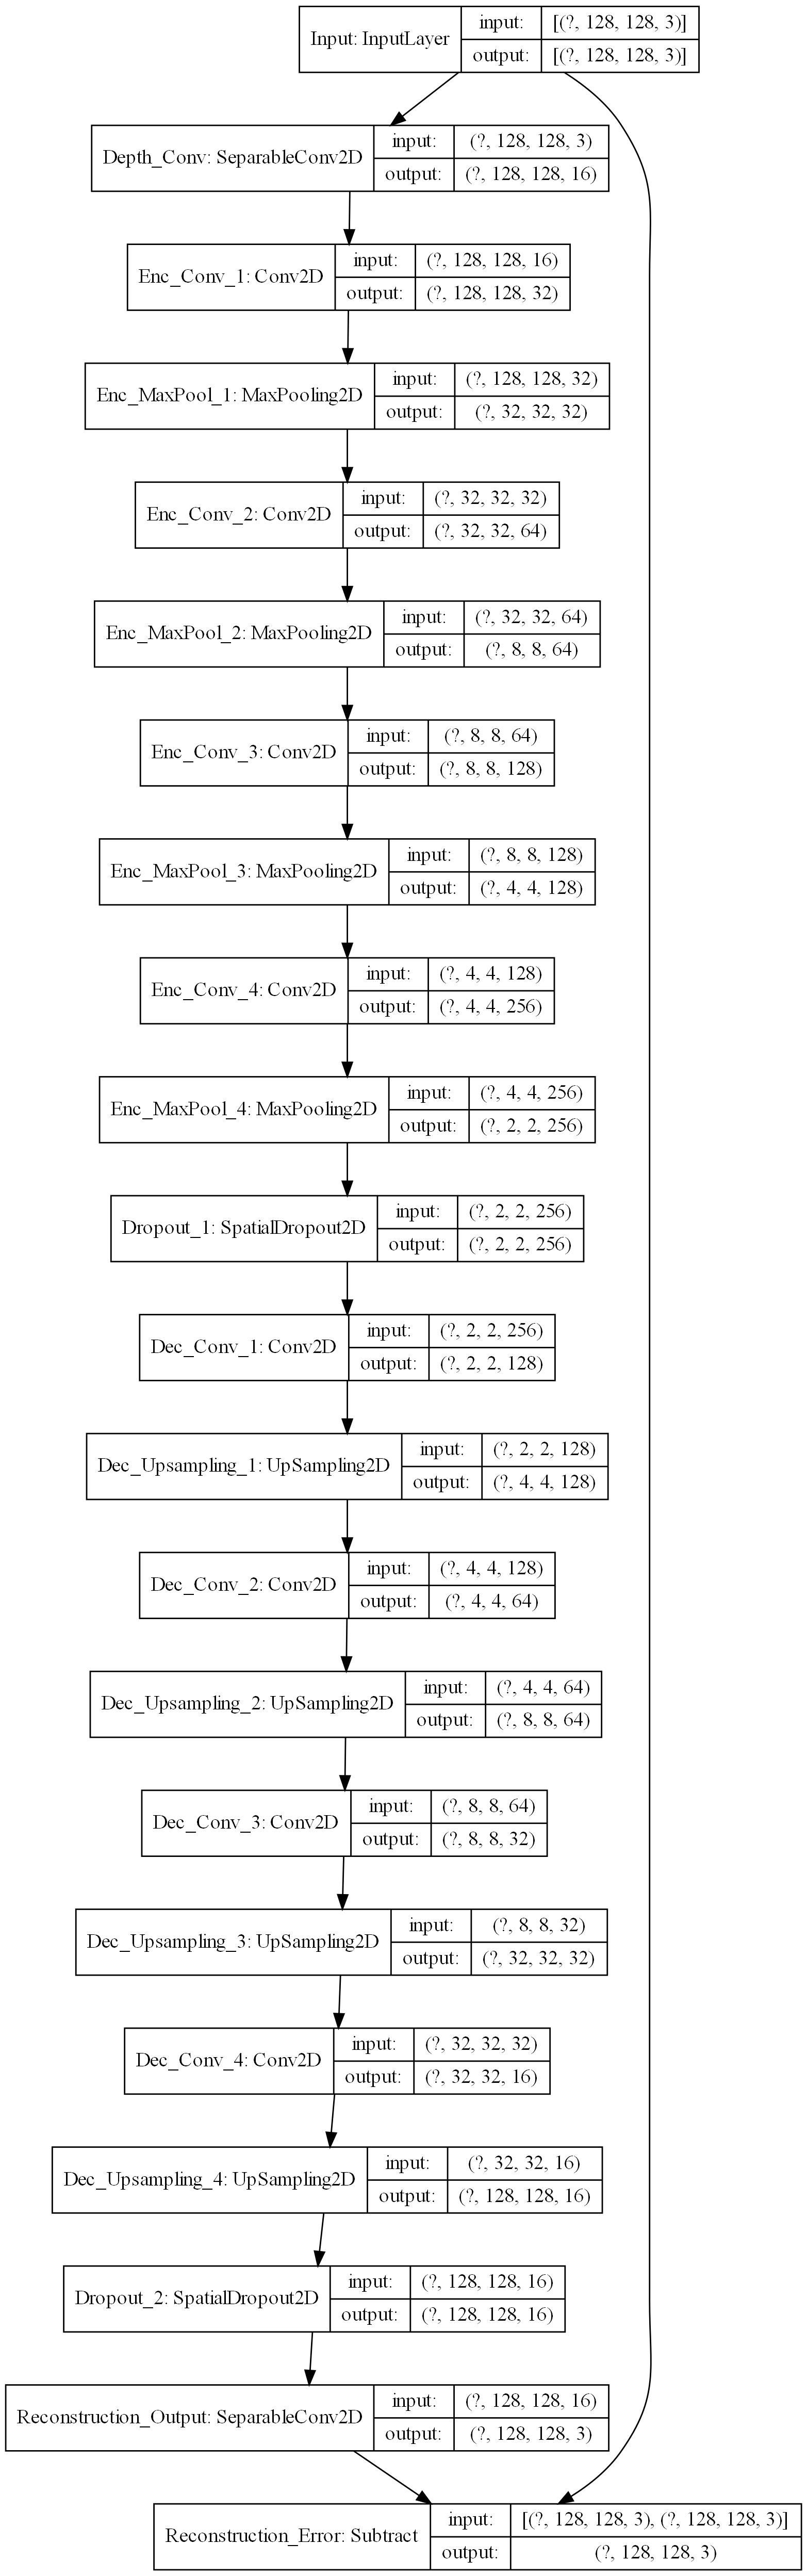

In [ ]:
tf.keras.utils.plot_model(classifier, to_file = os.path.join(PLOTS_DIR, 'model.jpg'), show_shapes = True, dpi = PLOTS_DPI)